# Mudcard 
- **what exactly is gain using to determine the accuracy through each feature?**
    - check the description [here](https://en.wikipedia.org/wiki/Information_gain_(decision_tree))
    - we don't need the exact definition of gain in this class but we cover it in more detail in DATA2060/CSCI1420 

## Local feature importance metrics
By the end of this module, you will be able to
- Describe motivation behind local feature importance metrics
- Apply SHAP
- Describe LIME

## <font color='LIGHTGRAY'>Local feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
- **Describe motivation behind local feature importance metrics**
- <font color='LIGHTGRAY'>Apply SHAP</font>
- <font color='LIGHTGRAY'>Describe LIME</font>

## Motivation
- can we trust the model?
   - global feature importance: does the model make predictions based on reasonable features?
   - local feature importance: can we trust the model's prediction for one specific data point?
- global feature importance is often not enough especially when you work with human data
   - medical: the doctor needs to be able to explain the reasoning behind the model prediction to the patient
   - finance: customer wants to know why they were declined a loan/mortgage/credit card/etc

## Global vs. local importance
- global: one value per feature, it is a vector of shape $(n_{ftrs})$
    - it describes how important each feature is generally
- local: one value per feature and data points, it is a 2D array with a shape of $(n_{points},n_{ftrs})$ - the same shape as your feature matrix
    - it describes how important each feature is for predicting one particular data point

## Motivation
<center><img src="figures/int_vs_acc.jpg" width="600"></center>

- local feature importance improves the interpretability of complex models 
- check out [this page](https://en.wikipedia.org/wiki/MNIST_database) for a good example

## <font color='LIGHTGRAY'>Local feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
- <font color='LIGHTGRAY'>Describe motivation behind local feature importance metrics</font>
- **Apply SHAP**
- <font color='LIGHTGRAY'>Describe LIME</font>

## SHAP values
- one way to calculate local feature importances
- it is based on Shapely values from game theory
- read more [here](https://arxiv.org/abs/1802.03888), [here](https://github.com/slundberg/shap), and [here](https://christophm.github.io/interpretable-ml-book/shap.html)

### Cooperative game theory
- A set of *m* players in a coalition generate a surplus.
- Some players contribute more to the coalition than others (different bargaining powers).
- How important is each player to the coalition?
- How should the surplus be divided fairly amongst the players?

### Cooperative game theory <font color='red'>applied to feature attribution</font>
- A set of *m* <font color='red'>features</font> in a <font color='red'>model</font> generate a <font color='red'>prediction</font>.
- Some <font color='red'>features</font> contribute more to the <font color='red'>model</font> than others (different <font color='red'>predictive</font> powers).
- How important is each <font color='red'>feature</font> to the <font color='red'>model</font>?
- How should the <font color='red'>prediction</font> be divided amongst the <font color='red'>features</font>?

## How is it calculated?
### $\Phi_i = \sum_{S\subseteq M\setminus i}  \frac{|S|!(M - |S| - 1)!} {M!} [f_x(S\cup i) - f_x(S)]$

- $\Phi_i$ - the contribution of feature $i$
- $M$ - the number of features
- $S$ - a set of features excluding $i$, a vector of 0s and 1s (0 if a feature is missing)
- $|S|$ - the number of features in $S$
- $f_x(S)$ - the prediction of the model with features $S$

This is the sum of how much feature i contribute to the prediction. The weight is related to combination theory -- M choose |S|.

## How is it calculated?
### $\Phi_i = \sum_{S\subseteq M\setminus i} \color{blue}{\frac{|S|!(M - |S| - 1)!} {M!}}\color{red}{[f_x(S\cup i) - f_x(S)]}$
- <font color='red'>the difference feature $i$ makes in the prediction: </font>
    - <font color='red'>$f_x(S\cup i)$ - the prediction with feature $i$</font>
    - <font color='red'>$f_x(S)$ - the prediction without feature $i$</font>
- loop through all possible ways a set of S features can be selected from the M features excluding i
- <font color='blue'>weight the contribution based on how many ways we can select $|S|$ features</font>

# Quiz 1

Let's calculate the weight term (in blue) of the shap equation. Let's assume we have 4 features and we want to calculate the shap value of one of them. Then M = 4, S can be [0,0,0], [1,0,0], [0,1,0],[0,0,1], [1,1,0], [1,0,1], [0,1,1], and [1,1,1]. What's |S| and the value of the blue term in each of these cases?

In [1]:
import math

M = 4
S_list = [[0,0,0], [1,0,0], [0,1,0], [0,0,1], [1,1,0], [1,0,1], [0,1,1], [1,1,1]]
for S in S_list:
    num_S = sum(S)
    print('|S| =', num_S)
    print('weight:', math.factorial(num_S) * math.factorial(M-num_S-1) / math.factorial(M))

|S| = 0
weight: 0.25
|S| = 1
weight: 0.08333333333333333
|S| = 1
weight: 0.08333333333333333
|S| = 1
weight: 0.08333333333333333
|S| = 2
weight: 0.08333333333333333
|S| = 2
weight: 0.08333333333333333
|S| = 2
weight: 0.08333333333333333
|S| = 3
weight: 0.25


- if |S| = 0, then 0!*(4-1)!/4! = 1/4.

- if |S| = 1, then 1!*(4-1-1)!/4! = 2!/4! = 1/12.

- if |S| = 2, then 2!*(4-2-1)!/4! = 1/12.

- if |S| = 3, then 3!*(4-3-1)!/4! = 1/4.

 

Note that |S| = 0 and 3 only once, while |S| = 1 and 2 three times. 1* 1/4 + 3* 1/12 + 3* 1/12 + 1* 1/4 = 1 so the sum of the weights is 1.

In [2]:
import numpy as np
import pandas as pd
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt

df = pd.read_csv('data/adult_data.csv')
label = 'gross-income'
y = df[label]
df.drop(columns=[label],inplace=True)
X = df
ftr_names = X.columns
print(X.head())
print(y)

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0          2174             0              40   United-States  
1           

In [3]:
def ML_pipeline_kfold(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,RandomForestClassifier(n_estimators =  100,random_state=random_state))
    # the parameter(s) we want to tune
    param_grid = {'randomforestclassifier__max_depth': [10,30,100,300],
                  'randomforestclassifier__min_samples_split': [16, 32, 64, 128]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = grid.best_estimator_[0].get_feature_names_out()
    return grid, np.array(feature_names), X_test, y_test

In [6]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold(X,y,42,4)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
0.862906941031941
0.8667280822969445
{'randomforestclassifier__max_depth': 100, 'randomforestclassifier__min_samples_split': 64}
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEn

In [5]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[1])
# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test)
print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


(6513, 108)
(2, 1000, 108)


In [7]:
print(grid.best_estimator_[0])

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'fnlwgt', 'education-num',
                                  'capital-gain', 'capital-loss',
                                  'hours-per-week']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationship', 'race', 'sex',
                                  'native-country'])])


## Explain a point

In [10]:
explainer.expected_value

array([0.75897535, 0.24102465])

In [8]:
index = 42 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = X_test_transformed[index,:],feature_names = feature_names)

0.7589753531941029


In [11]:
index = 0 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = X_test_transformed[index,:],feature_names = feature_names)

0.7589753531941029


## Feature value vs. shap value

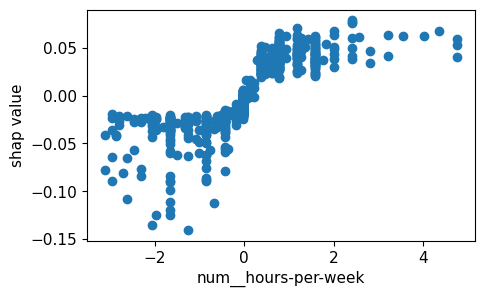

In [16]:
import matplotlib
matplotlib.rcParams.update({'font.size': 11})
ftr = 'num__hours-per-week'
indx = np.argwhere(feature_names==ftr)
plt.figure(figsize=(5,3))
plt.scatter(X_test_transformed[:1000,indx],shap_values[1][:,indx])
plt.ylabel('shap value')
plt.xlabel(ftr)
plt.show()


## Dependence plot

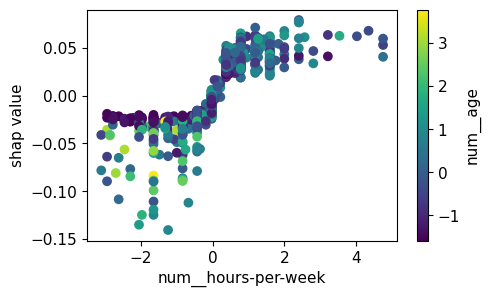

In [17]:
ftr1 = 'num__hours-per-week'
ftr2 = 'num__age'
indx1 = np.argwhere(feature_names==ftr1)
indx2 = np.argwhere(feature_names==ftr2)

plt.figure(figsize=(5,3))
plt.scatter(X_test_transformed[:1000,indx1],shap_values[1][:,indx1],c=X_test_transformed[:1000,indx2])
plt.ylabel('shap value')
plt.xlabel(ftr1)
plt.colorbar(label=ftr2)
plt.show()

## It can also be used for global feature importance

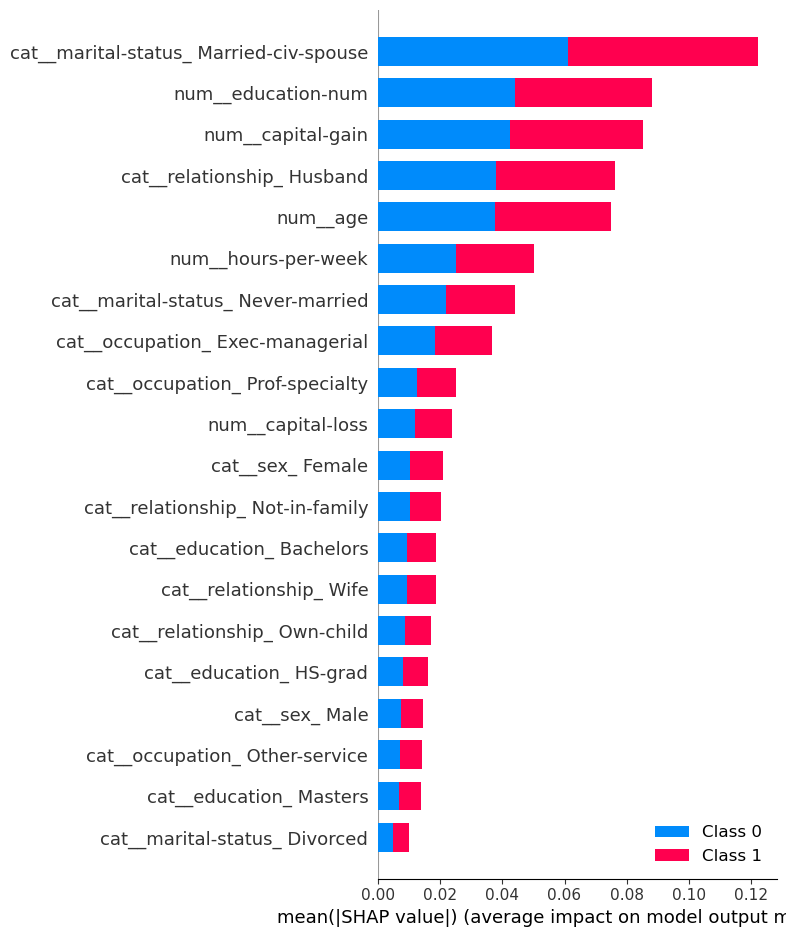

In [18]:
shap.summary_plot(shap_values, X_test_transformed[:1000],feature_names = feature_names)

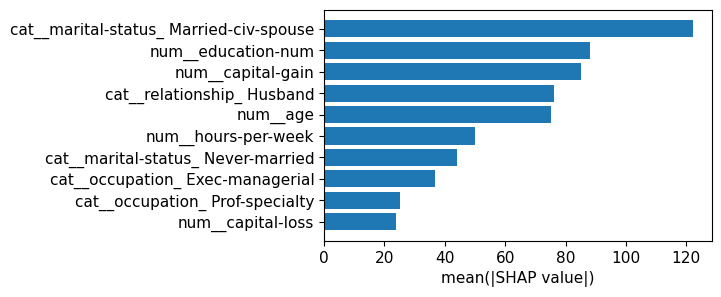

In [19]:
shap_summary = np.sum(np.abs(shap_values[1]),axis=0)+np.sum(np.abs(shap_values[0]),axis=0) # same shape as the number of features
indcs = np.argsort(shap_summary)
shap_summary[indcs]

plt.figure(figsize=(5,3))
plt.barh(feature_names[indcs[-10:]],shap_summary[indcs[-10:]])
plt.xlabel('mean(|SHAP value|)')
plt.show()

## SHAP cons
- it can be numerically expensive
   - an efficient shap method was developed for trees, see [here](https://arxiv.org/abs/1905.04610)
- how to estimate $f_x(S)$?
   - this is not trivial because models cannot change the number of features they use
   - usually the values of the dropped features are replaced with the mean or 0
   - this is approximate but no one came up with a better way 

## <font color='LIGHTGRAY'>Local feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
- <font color='LIGHTGRAY'>Describe motivation behind local feature importance metrics</font>
- <font color='LIGHTGRAY'>Apply SHAP</font>
- **Describe LIME**

## Locally Interpretable Model-agnostic Explanations
- read about it [here](https://github.com/marcotcr/lime), [here](https://arxiv.org/abs/1602.04938), and [here](https://christophm.github.io/interpretable-ml-book/lime.html)
- LIME generates a new dataset consisting of perturbed samples and the corresponding predictions of the black box model. On this new dataset LIME then trains an interpretable model, which is weighted by the proximity of the sampled instances to the instance of interest. 
- classification and regression models can be complex and explaining the whole model is challenging
- let's focus on one point at a time
- generate an interpretable model (linear regression) in the local neighborhood of that one point 
- study the coefficients of that model

## LIME steps:
- select a data point you want to explain
- generate random samples
- weight the samples based on their distance from the data point of interest (exponential kernel)
- train a linear regression model (usually lasso) using the weighted samples
- study the local model around the point

<center><img src="figures/LIME.jpg" width="600"></center>

## Cons, the devil is in the details
- the random samples are not taken around the data point of interest
- how to define the half width of the kernel?
   - the explanation can be very sensitive to the kernel width
   - there is no good way to define/measure what a good kernel width is
- the distance measure treats each feature equally which can be problematic

# Mudcard